In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import curve_fit

import ipywidgets as widgets
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u

# Telescope Position Data

In [2]:
lst, alt, az, ra, dec = np.loadtxt('data/telescope_orientation.csv', delimiter=',', unpack=True)
ha = lst - ra

<IPython.core.display.Javascript object>


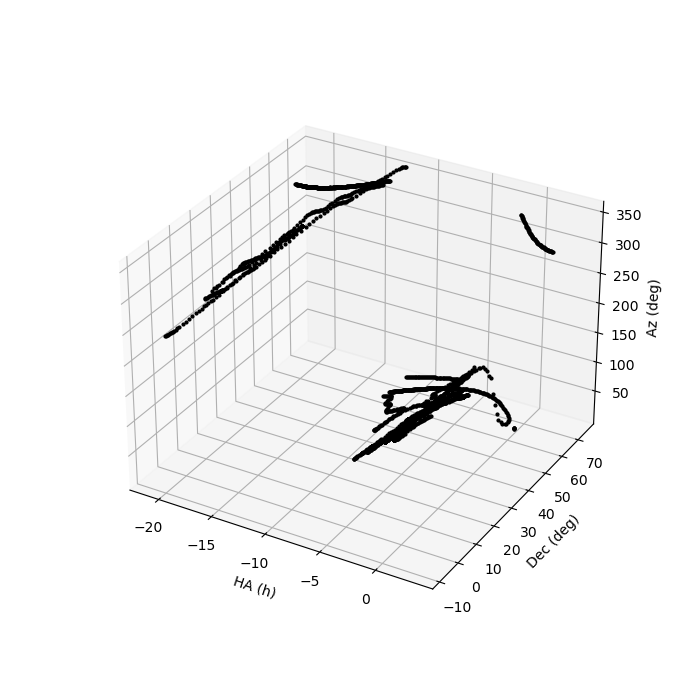

In [3]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)
# frame.set_xlim(-5, 5)
# frame.set_ylim(-5, 5)
# frame.set_zlim(0, 5)

frame.set_xlabel('HA (h)')
frame.set_ylabel('Dec (deg)')
frame.set_zlabel('Az (deg)')

plt.plot(ha, dec, az, color='black', ls='', marker='o', ms=2)
plt.show()

# Computing HA

In [4]:
def compute_ha(ra, date):
    observing_location = EarthLocation(lat=53.240243*u.deg, lon=6.53651*u.deg) # Blaauw Observatory
    observing_time = Time(date, scale='utc', location=observing_location)
    lst = observing_time.sidereal_time('mean')
    
    print('LST = {:.5f} h'.format(lst.hour))
    
    return lst.hour - ra

## 13:17

In [5]:
ra_ex = 6 + 2 * 1/60 + 7 * 1/3600
dec_ex = 50 + 50 * 1/60
ha_ex = compute_ha(ra_ex, datetime(2021, 5, 14, hour=11, minute=17))

print('HA = {:.2f} h = {:.2f} deg & Dec = {:.2f} deg'.format(ha_ex, ha_ex * 15, dec_ex))

LST = 3.21393 h
HA = -2.82 h = -42.32 deg & Dec = 50.83 deg


## 13:19

In [6]:
ra_ex = 6 + 28 * 1/60 + 1 * 1/3600
dec_ex = 7 + 50 * 1/60 # deg
ha_ex = compute_ha(ra_ex, datetime(2021, 5, 14, hour=11, minute=19)) 

print('HA = {:.2f} h = {:.2f} deg & Dec = {:.2f} deg'.format(ha_ex, ha_ex * 15, dec_ex))

LST = 3.24736 h
HA = -3.22 h = -48.29 deg & Dec = 7.83 deg


# The Altitude

In [7]:
def altitude(ha, dec):
    """Returns altitude (in Grunn) in deg."""
    lat = np.radians(53.24)
    dec = np.radians(dec)
    ha  = np.radians(ha)
    
    term_1 = np.sin(dec)*np.sin(lat)
    term_2 = np.cos(dec)*np.cos(lat)*np.cos(ha)
    
    a = np.degrees(np.arcsin(term_1 + term_2))
    
    return a

# 2D Polynomial Fitting

# Visualizing Obstruction Data

In [8]:
from joblib import Parallel, delayed, dump, load

file_name = lambda n: '../scripts/data/blocked_grid_az_' + str(n) + '.joblib'
azs = np.arange(0, 360, 2)

In [9]:
cube = []

for n_az in azs:
    with open(file_name(n_az), 'rb') as f:
        data = load(f)
        cube.append(data)
#         print('az = {:.2f} deg w/ shape = {}'.format(n_az, data.shape))

cube = np.array(cube)

In [10]:
_az = np.linspace(0, 359, 180)
_h = np.linspace(-180, 180, 181)
_dec = np.linspace(-90, 90, 91)

az, h, dec = np.meshgrid(_az, _h, _dec, indexing='ij')

alt = altitude(h, dec)

cond_1 = cube == cube.min()
cond_2 = alt >= 15

cond = cond_1 & cond_2

h_selected = h[cond]
h_out = np.where(h_selected < 0, h_selected + 360, h_selected) # offset hour angle

dec_selected = dec[cond]
az_selected = az[cond]

In [11]:
h_lin = h.ravel()
dec_lin = dec.ravel()
az_lin = az.ravel()

b = cube.ravel()

coords = np.column_stack((h_lin, dec_lin))

In [12]:
h_range = np.arange(h_selected.min(), h_selected.max() + 2, 2)
dec_range = np.arange(dec_selected.min(), dec_selected.max() + 2, 2)

In [13]:
coords = []
azimuths = []

for h in h_range:
    for dec in dec_range:
        cond = np.isclose(h_selected, h)&np.isclose(dec_selected, dec)
        
        az_min = None
        
        try:
            az_min = az_selected[cond].min()
        except:
            pass
        
        if az_min is not None:
            coords.append((h, dec))
            azimuths.append(az_min)

coords = np.array(coords)
azimuths = np.array(azimuths)

## Plot

<IPython.core.display.Javascript object>


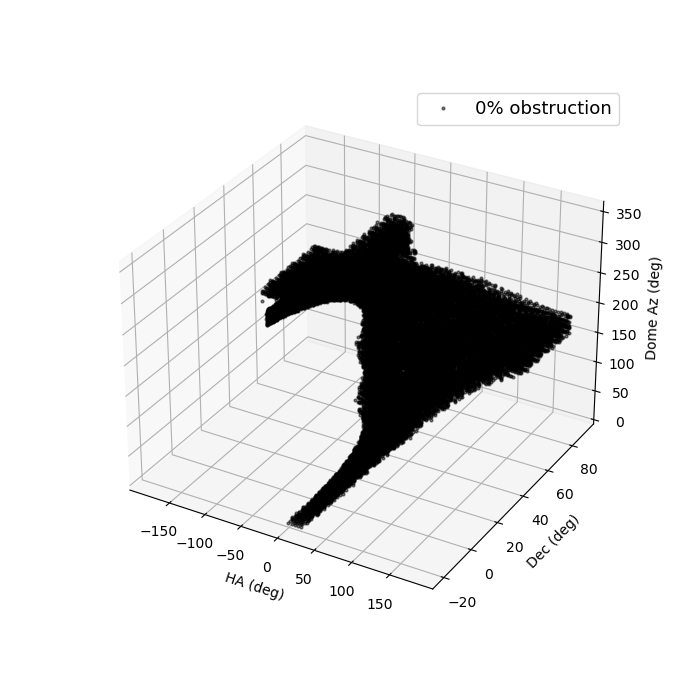

In [14]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)

frame.set_xlabel('HA (deg)')
frame.set_ylabel('Dec (deg)')
frame.set_zlabel('Dome Az (deg)')

frame.plot(h_selected[::4], dec_selected[::4], az_selected[::4], color='black', ls='', alpha=0.5, marker='o', ms=2, label='0% obstruction')
# frame.plot(h_out[::4], dec_selected[::4], az_selected[::4], color='xkcd:salmon', ls='', alpha=0.1, marker='o', ms=2)

# frame.plot(h_sel, dec_sel, 180, color='xkcd:salmon', ls='', alpha=0.5, marker='o', ms=2)
# plt.plot(h_selected[np.isclose(az_selected, 359.)], dec_selected[np.isclose(az_selected, 359.)], az_selected[np.isclose(az_selected, 359.)], color='purple', ls='', alpha=0.5, marker='o', ms=2, label='$A_z=359$ deg')

# hs, ds = coords.T
# frame.plot(hs, ds, azimuths, color='xkcd:green', ls='', alpha=0.8, marker='o', ms=2, label='$\min(A_z)$ w/ 0% obstruction')

# frame.view_init(elev=90, azim=90)

frame.legend(fontsize=13)

plt.show()

## Selecting $A_d$ Values Given $(h,\delta)$ Pairs

In [15]:
@widgets.interact(ha=(-180, 180, 2.0), dec=(-90, 90, 2.0))
def update(ha=0.0, dec=0.0):
    # Select indices according to the given ha/dec
    dec_sel = np.argwhere(np.isclose(dec_selected, dec)).ravel()
    h_sel   = np.argwhere(np.isclose(h_selected, ha)).ravel()
    
    indices = np.intersect1d(h_sel, dec_sel)
    
    # Find the range of azimuth values
    az = az_selected[indices]
    
    # Display the results
    if not az.size:
        print('No azimuths available!')
    else:
        print('Available az (deg):\n')
        
        for a in az:
            print('{:.2f}'.format(a), end=', ')

interactive(children=(FloatSlider(value=0.0, description='ha', max=180.0, min=-180.0, step=2.0), FloatSlider(v…

## Store the Data

In [16]:
sel = np.column_stack([h_selected, dec_selected, az_selected])
np.savetxt('zero_obstruction_v3.txt', sel, delimiter=',')

## Fitting

_Maybe look @ this_ [SO Question](https://stackoverflow.com/questions/33964913/equivalent-of-polyfit-for-a-2d-polynomial-in-python)

In [17]:
# h_max = 180
# delta_max = 90

# def fourier_2d(x, a, b, c, d, e, f, g, h, i, j, k, l, m):
#     h, delta = x
#     x_term = lambda n: np.pi * h / h_max
#     y_term = lambda m: np.pi * delta / delta_max
    
# #     f = p[0] + p[1]*np.cos(x_term(1))*np.cos(y_term(1)) + p[2]*np.sin(x_term(1))*np.cos(y_term(1)) \
# #         + p[3]*np.cos(x_term(1))*np.sin(y_term(1)) + p[4]*np.sin(x_term(1))*np.sin(y_term(1))
#     f = a + b*np.cos(x_term(1))*np.cos(y_term(1)) + c*np.sin(x_term(1))*np.cos(y_term(1)) \
#         + d*np.cos(x_term(1))*np.sin(y_term(1)) + e*np.sin(x_term(1))*np.sin(y_term(1)) \
#         + f*np.cos(x_term(2))*np.cos(y_term(2)) + g*np.sin(x_term(2))*np.cos(y_term(2)) \
#         + h*np.cos(x_term(2))*np.sin(y_term(2)) + i*np.sin(x_term(2))*np.sin(y_term(2)) \
#         + j*np.cos(x_term(3))*np.cos(y_term(3)) + k*np.sin(x_term(3))*np.cos(y_term(3)) \
#         + l*np.cos(x_term(3))*np.sin(y_term(3)) + m*np.sin(x_term(3))*np.sin(y_term(3))
    
#     return f

# p_init = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
# ps, cov = curve_fit(fourier_2d, (h_selected, dec_selected), az_selected, p_init)

# _h = np.linspace(-180, 180, 181)
# _dec = np.linspace(-35, 90, 91)

# h, dec = np.meshgrid(_h, _dec, indexing='ij')
# az_pred = fourier_2d((h, dec), *ps)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(h, dec, az_pred)

# ax.set_xlabel('HA')
# ax.set_ylabel('Dec')
# ax.set_zlabel('Az')

# plt.show()

# Above 15 deg

In [18]:
h, dec = np.meshgrid(_h, _dec, indexing='ij')

In [19]:
alt = altitude(h, dec)
cond = alt >= 15

<IPython.core.display.Javascript object>


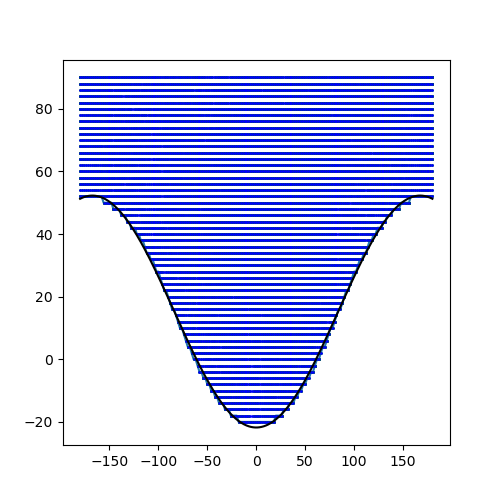

In [20]:
# %matplotlib inline

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

h_sel = h[cond]
dec_sel = dec[cond]

# plt.scatter(h_sel, dec_sel, s=2)


plt.show()

In [21]:
decs = []
for h in _h:
    min_dec = dec_sel[h_sel == h].min()
    
    decs.append(min_dec)

decs = np.array(decs)

In [22]:
plt.plot(_h, decs)

In [23]:
def cos_func(x, a, b, c):
    return a*np.cos(b*x)+c

p_init = (-40, 0.05, 20)
ps, cov = curve_fit(cos_func, _h, decs, p_init)

In [24]:
h_range = np.linspace(-180, 180, 500)

In [25]:
plt.plot(h_selected[::4], dec_selected[::4], color='green', ls='', marker='o', ms=1)

# plt.scatter(_h, decs, s=2, alpha=0.5, color='blue')
plt.plot(h_sel, dec_sel, color='blue', ls='', marker='o', ms=1)
plt.plot(h_range, cos_func(h_range, *ps), color='black')